Starbucks Capstone Project

Starbucks has an app that gives individually tailored coupons to app users in hopes that the coupon entices people into their stores. So their objective with this dataset is to discern which types of users should receive which types of coupons.

This project is to identify the conditions under which a Starbucks App user will respond to a coupon that was randomly given to them. Note that some customers would have gone to Starbucks regardless of whether or not they received a coupon. So this model will then give a prediction as to whether any given customer, if they are given a specific coupon, will *change* their behavior and go to Starbucks. 

There are a few difficulties with this that we will deal with as they occur, but the overall goal is to clean the dataset for exploratory analysis, then feed it into a predictive model that will assess whether or not they will buy a product after viewing the coupon. 

Overall, we were able to make a model that, after removing all trivially predictable data, was able to correctly predict consumer behavior 77.1% of the time. 

In [1]:
# import essentials
import pandas as pd
import numpy as np
import math
import json
import re
import seaborn as sns
import matplotlib.pyplot as plt
% matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# set our seaborn style
sns.set_style('darkgrid')
pd.options.display.float_format = '{:,.2f}'.format

In [3]:
seed = 69 # Bill & Ted > 42
np.random.seed(seed) 

In [ ]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [7]:
# multiple dataframes have an 'id' column, each one means something different
# clarify the id variables
portfolio.rename(columns={'id':'coupon_id'},inplace=True)
portfolio.head()

,reward,channels,difficulty,duration,offer_type,coupon_id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7


In [8]:
profile.rename(columns={'id':'customer_id'},inplace=True)
profile.became_member_on = pd.to_datetime(profile.became_member_on,format='%Y%m%d')
profile.head()

,gender,age,customer_id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,2017-02-12,nan
1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,"112,000.00"
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,2018-07-12,nan
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,"100,000.00"
4,None,118,a03223e636434f42ac4c3df47e8bac43,2017-08-04,nan


In [9]:

transcript['event_id'] = transcript.value.apply(
    lambda x: list(x.values())[0]
)

In [10]:
transcript.head()

,person,event,value,time,event_id
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0


In [11]:
df = transcript.join(profile.set_index('customer_id'),on='person')
df = df.join(portfolio.set_index('coupon_id'),on='event_id')
df.head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,9b98b8c7a33c4b65b9aebfe6a799e6d9,F,75,2017-05-09,"100,000.00",5.00,"[web, email, mobile]",5.00,7.00,bogo
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0b1e1539f2cc45b7b9fa7c272da2e1d7,None,118,2017-08-04,nan,5.00,"[web, email]",20.00,10.00,discount
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2906b810c7d4411798c6938adc9daaa5,M,68,2018-04-26,"70,000.00",2.00,"[web, email, mobile]",10.00,7.00,discount
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,fafdcd668e3743c1bb461111dcafc2a4,None,118,2017-09-25,nan,2.00,"[web, email, mobile, social]",10.00,10.00,discount
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4d5c57ea9a6940dd891ad53e9dbe8da0,None,118,2017-10-02,nan,10.00,"[web, email, mobile, social]",10.00,5.00,bogo


In [12]:
transcript.event.unique()

array(['offer received', 'offer viewed', 'transaction', 'offer completed'],
      dtype=object)

In [13]:
transaction = df[df.event=='transaction'].copy()
transaction.head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
12654,02c083884c7d45b39cc68e1314fec56c,transaction,{'amount': 0.8300000000000001},0,0.83,F,20,2016-07-11,"30,000.00",nan,NaN,nan,nan,NaN
12657,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,transaction,{'amount': 34.56},0,34.56,M,42,2016-01-17,"96,000.00",nan,NaN,nan,nan,NaN
12659,54890f68699049c2a04d415abc25e717,transaction,{'amount': 13.23},0,13.23,M,36,2017-12-28,"56,000.00",nan,NaN,nan,nan,NaN
12670,b2f1cd155b864803ad8334cdf13c4bd2,transaction,{'amount': 19.51},0,19.51,F,55,2017-10-16,"94,000.00",nan,NaN,nan,nan,NaN
12671,fe97aa22dd3e48c8b143116a8403dd52,transaction,{'amount': 18.97},0,18.97,F,39,2017-12-17,"67,000.00",nan,NaN,nan,nan,NaN


In [14]:
viewed = df[df.event=='offer viewed'].copy()

In [15]:
completed = df[df.event=='offer completed'].copy()
completed.head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type
12658,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,offer completed,{'offer_id': '2906b810c7d4411798c6938adc9daaa5...,0,2906b810c7d4411798c6938adc9daaa5,M,42,2016-01-17,"96,000.00",2.00,"[web, email, mobile]",10.00,7.00,discount
12672,fe97aa22dd3e48c8b143116a8403dd52,offer completed,{'offer_id': 'fafdcd668e3743c1bb461111dcafc2a4...,0,fafdcd668e3743c1bb461111dcafc2a4,F,39,2017-12-17,"67,000.00",2.00,"[web, email, mobile, social]",10.00,10.00,discount
12679,629fc02d56414d91bca360decdfa9288,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,M,52,2018-06-05,"72,000.00",5.00,"[web, email, mobile]",5.00,7.00,bogo
12692,676506bad68e4161b9bbaffeb039626b,offer completed,{'offer_id': 'ae264e3637204a6fb9bb56bc8210ddfd...,0,ae264e3637204a6fb9bb56bc8210ddfd,M,37,2017-05-15,"92,000.00",10.00,"[email, mobile, social]",10.00,7.00,bogo
12697,8f7dd3b2afe14c078eb4f6e6fe4ba97d,offer completed,{'offer_id': '4d5c57ea9a6940dd891ad53e9dbe8da0...,0,4d5c57ea9a6940dd891ad53e9dbe8da0,M,48,2015-09-03,"62,000.00",10.00,"[web, email, mobile, social]",10.00,5.00,bogo


In [16]:
received = df[df.event=='offer received'].copy()
received.shape

(76277, 14)

In [17]:
# now add coupon viewed, and coupon completed to received
# start with viewed
def check_feat(df,other) :
    output = pd.Series(np.zeros(received.shape[0]),dtype=int)
    for i,row in received.iterrows() :
        temp = other[other.person == row.person]
        temp = temp[temp.event_id==row.event_id]
        temp = temp[temp.time >= row.time]
        temp = temp[temp.time <= row.time + (row.duration * 24)]
        if temp.shape[0] > 0 : output[i] = 1
        else : output[i] = 0
    return output

In [18]:
from time import time
t = time()

This code will take a while. For google colab, it takes a little over 30 minutes without GPU assistance.

In [19]:
received['viewed'] = check_feat(df,viewed)

In [20]:
received['completed'] = check_feat(df,completed)

In [21]:
print(time()-t)

1886.4447572231293


In [22]:
# anyone who completes the offer without viewing it shouldnt be counted
received.completed *= received.viewed

In [23]:
from sklearn.preprocessing import LabelEncoder

In [24]:
labelencoder = LabelEncoder()
received.event_id = labelencoder.fit_transform(received.event_id)

In [25]:
received.head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,6,F,75,2017-05-09,"100,000.00",5.00,"[web, email, mobile]",5.00,7.00,bogo,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,None,118,2017-08-04,nan,5.00,"[web, email]",20.00,10.00,discount,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2,M,68,2018-04-26,"70,000.00",2.00,"[web, email, mobile]",10.00,7.00,discount,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,9,None,118,2017-09-25,nan,2.00,"[web, email, mobile, social]",10.00,10.00,discount,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4,None,118,2017-10-02,nan,10.00,"[web, email, mobile, social]",10.00,5.00,bogo,1,0


In [26]:
# find most recent start date
date_max = received.became_member_on[received.became_member_on.argsort()==(received.shape[0]-1)].values[0]
date_max

numpy.datetime64('2016-05-01T00:00:00.000000000')

In [27]:
received.completed.mean()

0.36573278970069617

In [28]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn_pandas import DataFrameMapper
from category_encoders import LeaveOneOutEncoder
from scipy.stats import skew

In [29]:
from sklearn.model_selection import train_test_split

Now for some data visualization

In [30]:
received.head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,viewed,completed
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0,6,F,75,2017-05-09,"100,000.00",5.00,"[web, email, mobile]",5.00,7.00,bogo,1,1
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,None,118,2017-08-04,nan,5.00,"[web, email]",20.00,10.00,discount,1,0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0,2,M,68,2018-04-26,"70,000.00",2.00,"[web, email, mobile]",10.00,7.00,discount,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,9,None,118,2017-09-25,nan,2.00,"[web, email, mobile, social]",10.00,10.00,discount,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4,None,118,2017-10-02,nan,10.00,"[web, email, mobile, social]",10.00,5.00,bogo,1,0


In [31]:
received.income.max()

120000.0

In [32]:
completed_series = received.completed.astype('category').cat.rename_categories(['No','Yes'])
completed_series

0         Yes
1          No
2          No
3          No
4          No
         ... 
257882    Yes
257883     No
257884     No
257885    Yes
257886     No
Name: completed, Length: 76277, dtype: category
Categories (2, object): ['No', 'Yes']

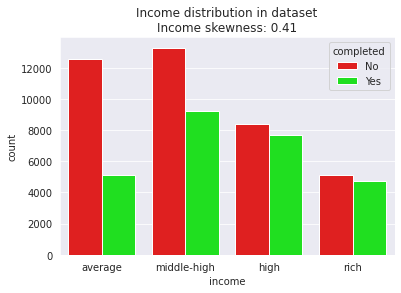

In [33]:
plt.title('Income distribution in dataset\n'
'Income skewness: {:.2f}'.format(received.income.skew()))
fig = sns.countplot(pd.cut(received.income,bins=[30000,50000,70000,90000,120000],
              labels=['average','middle-high','high','rich']),
              hue=completed_series,palette=['r','#00ff00'])

It looks like the higher a person's income, the more likely they are to use a coupon after viewing it

In [34]:
received['income'].describe()

count    66,501.00
mean     65,371.62
std      21,623.29
min      30,000.00
25%      49,000.00
50%      64,000.00
75%      80,000.00
max     120,000.00
Name: income, dtype: float64

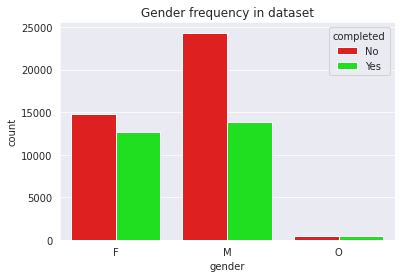

In [35]:
plt.title('Gender frequency in dataset')
fig = sns.countplot(x=received.gender,hue=completed_series,palette=['r','#00ff00']);

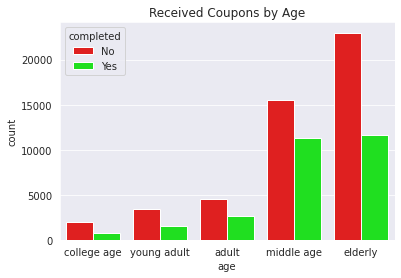

In [36]:
plt.title('Received Coupons by Age')
fig = sns.countplot(x=pd.cut(received.age,bins=[17,22,30,40,60,118],
        labels=['college age','young adult','adult','middle age','elderly']),
        hue=completed_series, palette=['r','#00ff00'])

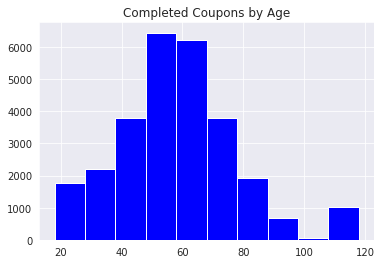

In [37]:
# now check the ages of people who complete these coupons
plt.title('Completed Coupons by Age')
received[completed_series=='Yes'].age.hist(color='b');

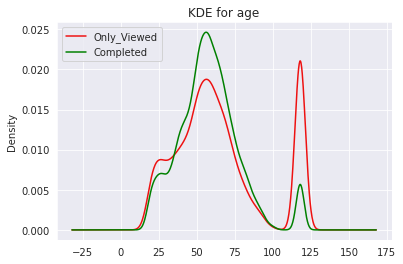

In [38]:
kde_df = pd.DataFrame({
    'Only_Viewed':received[received.completed==0].age,
    'Completed':received[received.completed==1].age
}).plot.kde(title='KDE for age',color=['#ee1111','g']);

Surprisingly, the age of a customer doesnt seem to have much impact on whether they redeem their coupon.
But, we have a large number of people at the maximum age. Let's look closer.

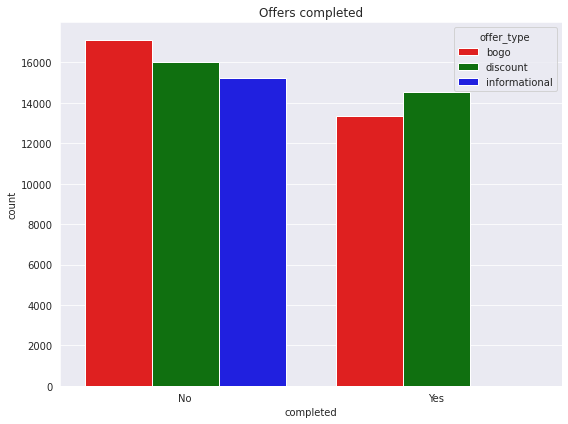

In [39]:
plt.figure(figsize=(8,6))

fig = sns.countplot(x=completed_series,
                    hue=received['offer_type'],
                    palette=['red','green','blue'],
                    ).set_title('Offers completed')
plt.tight_layout()

In [40]:
received[received.offer_type=='informational'].completed.value_counts()

0    15235
Name: completed, dtype: int64

All informational offers are not completed. We should drop this when cleaning for prediction

In [41]:
received[received['age']==118].head()

,person,event,value,time,event_id,gender,age,became_member_on,income,reward,channels,difficulty,duration,offer_type,viewed,completed
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,None,118,2017-08-04,nan,5.00,"[web, email]",20.00,10.00,discount,1,0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0,9,None,118,2017-09-25,nan,2.00,"[web, email, mobile, social]",10.00,10.00,discount,1,0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0,4,None,118,2017-10-02,nan,10.00,"[web, email, mobile, social]",10.00,5.00,bogo,1,0
6,c4863c7985cf408faee930f111475da3,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},0,1,None,118,2017-08-24,nan,3.00,"[web, email, mobile, social]",7.00,7.00,discount,1,0
10,744d603ef08c4f33af5a61c8c7628d1c,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0,0,None,118,2017-08-01,nan,5.00,"[web, email]",20.00,10.00,discount,1,0


age 118 seems to have errors with its data collection. All income is NaN and all gender is None. Drop these rows.

In [42]:
received[received['age']!=118]['age'].describe()

count   66,501.00
mean        54.37
std         17.40
min         18.00
25%         42.00
50%         55.00
75%         66.00
max        101.00
Name: age, dtype: float64

In [43]:
received.offer_type.unique()

array(['bogo', 'discount', 'informational'], dtype=object)

In [44]:
def clean_dataframe(df:pd.DataFrame) :
    """
    clean a dataframe
    :param df: dataframe to be cleaned
    :return: cleaned dataframe
    """
    age_imputer = SimpleImputer()
    income_imputer = SimpleImputer()
    age_min_max_scaler = MinMaxScaler()
    year_min_max_scaler = MinMaxScaler()
    month_min_max_scaler = MinMaxScaler()
    day_min_max_scaler = MinMaxScaler()
    time_min_max_scaler = MinMaxScaler()
    channels_min_max_scaler = MinMaxScaler()
    difficulty_min_max_scaler = MinMaxScaler()
    duration_min_max_scaler = MinMaxScaler()
    reward_min_max_scaler = MinMaxScaler()
    income_min_max_scaler = MinMaxScaler()
    leave_one_out = LeaveOneOutEncoder()
    member_min_max_scaler = MinMaxScaler()

    df = df.copy()

    # drop all informational events because they cant be completed
    df = df[df.offer_type != 'informational']
    df['bogo'] = df.offer_type.apply(
        lambda x: x == 'bogo'
    ).astype(int)

    df['female'] = df['gender'].apply(lambda x : x=='F').astype(int)
    df['other'] = df['gender'].apply(lambda x : x=='O').astype(int)
    # I dont know many 118 year old people with smartphones, 
    # but I know a lot of < 118 people who lie
    df = df[df['age']!=118]
    df = df[df['viewed']==1]

    df['member_for_days'] = df['became_member_on'].apply(
        lambda x: (date_max - x).days
    )

    # completion only counts if they know about it
    df = df[df['viewed']==1]

    df['num_channels'] = df['channels'].apply(lambda x: len(str(x).split(','))/4)

    df['channel_social'] = df['channels'].apply(lambda x: 'social' in str(x)).astype(int)
    df['channel_mobile'] = df['channels'].apply(lambda x: 'mobile' in str(x)).astype(int)
    df['channel_web'] = df['channels'].apply(lambda x: 'web' in str(x)).astype(int)

    mapper = DataFrameMapper([
        (['bogo'],None),
        (['female'],None),
        (['other'],None),
        (['reward'],[reward_min_max_scaler]),
        (['event_id'],None),
        (['num_channels'],None),
        (['age'], [age_imputer, age_min_max_scaler], {'alias':'age_scaled'}),
        (['income'],[income_imputer,income_min_max_scaler],{'alias':'income_scaled'}),
        (['member_for_days'],[member_min_max_scaler]),
        (['difficulty'],[difficulty_min_max_scaler],{'alias':'difficulty_scaled'}),
        (['duration'],[duration_min_max_scaler],{'alias':'duration_scaled'})
    ],df_out=True)

    y = df.pop('completed')
    mapper.fit(X=df,y=y)
    X = mapper.transform(X=df)
    df = pd.concat([X,y],axis=1).rename(columns={
        'offer_type_x0_bogo':'bogo',
        'offer_type_x0_discount':'discount',
        'offer_type_x0_informational':'informational'})
    return df,mapper # return mapper for easy mapping future test data

In [45]:
def add_feats(df) :
    scale_cols = ['reward','age_scaled','income_scaled']
    for col in scale_cols :
        df[col+'_2'] = df[col]**2

    return df

In [46]:
df_clean,mapper = clean_dataframe(received)
df_clean = add_feats(df_clean)
df_clean.head()

,bogo,female,other,reward,event_id,num_channels,age_scaled,income_scaled,member_for_days,difficulty_scaled,duration_scaled,completed,reward_2,age_scaled_2,income_scaled_2
0,1,1,0,0.38,6,0.75,0.69,0.78,0.24,0.00,0.40,1,0.14,0.47,0.60
2,0,0,0,0.00,2,0.75,0.60,0.44,0.05,0.33,0.40,0,0.00,0.36,0.20
5,1,0,0,0.38,8,1.00,0.57,0.26,0.09,0.00,0.00,1,0.14,0.32,0.07
8,0,1,0,0.38,0,0.50,0.52,0.30,0.17,1.00,1.00,0,0.14,0.27,0.09
9,0,1,0,0.38,0,0.50,0.53,0.46,0.49,1.00,1.00,0,0.14,0.28,0.21


More data visualization

In [47]:
X_train,X_test,y_train,y_test = train_test_split(df_clean.drop(columns=['completed']),df_clean['completed'],test_size=.2)

In [48]:
pd.concat([y_train,X_train],axis=1).head()

,completed,bogo,female,other,reward,event_id,num_channels,age_scaled,income_scaled,member_for_days,difficulty_scaled,duration_scaled,reward_2,age_scaled_2,income_scaled_2
58721,0,1,1,0,0.38,6,0.75,0.53,0.49,0.09,0.00,0.40,0.14,0.28,0.24
201981,0,1,0,0,0.38,8,1.00,0.69,0.50,0.02,0.00,0.00,0.14,0.47,0.25
9724,1,1,0,0,0.38,8,1.00,0.28,0.32,0.20,0.00,0.00,0.14,0.08,0.10
162050,1,1,1,0,1.00,4,1.00,0.66,0.73,0.05,0.33,0.00,1.00,0.44,0.54
245843,1,1,1,0,1.00,4,1.00,0.39,0.69,0.32,0.33,0.00,1.00,0.15,0.47


In [49]:
y_train[:5]

58721     0
201981    0
9724      1
162050    1
245843    1
Name: completed, dtype: int64

In [50]:
# regression tiiiiime

In [51]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from time import time

In [52]:
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, f1_score

In [53]:
def evaluate(model,params=None,X_train=X_train,X_test=X_test,y_train=y_train,y_test=y_test) :
    t = time()
    if params is None : clf = model
    else : clf = GridSearchCV(model,params,scoring='accuracy')
    clf.fit(X_train,y_train)

    y_pred = clf.predict(X_train)
    print('train accuracy: {:.3f}'.format(accuracy_score(y_train,y_pred)))
    y_pred = clf.predict(X_test)
    print('test accuracy: {:.3f}'.format(accuracy_score(y_test,y_pred)))
    print('test f1 score: {:.3f}'.format(f1_score(y_test,y_pred)))
    print(confusion_matrix(y_test,y_pred,normalize='all'))
    print('fitted in {:.1f}s'.format(time()-t))
    if params : print(clf.best_params_)
    return clf

In [54]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

In [55]:
# for some of our more promising models, make a param grid to search over

forest_param_grid = {
    'n_estimators':600,
    'max_depth':12,
    'random_state':seed,   
}

xgb_param_grid = {
    'n_estimators':600, 
    'colsample_bytree':.7, #.7 best
    'gamma':1, # 1 is best
    'max_depth':12, # go up
    'subsample':1, # between .8 and 1
    'lambda':1
}

lgbm_param_grid = {
    'n_estimators':600, 
    'colsample_bytree':.9,
    'gamma':1, 
    'max_depth':12, 
    'subsample':1, 
    'lambda':1
}

In [56]:
tree = DecisionTreeClassifier()
bayes = GaussianNB()
kneighbors = KNeighborsClassifier()
logit = LogisticRegression(max_iter=10000)
forest = RandomForestClassifier(**forest_param_grid)
lgbm = LGBMClassifier(**lgbm_param_grid)
xgb = XGBClassifier(**xgb_param_grid)

# I originally put param grids in here to perform a gridsearch, but that would 
# be too time-intensive for you. I just picked a 
models = {
    'tree':[tree,None],
    'bayesian':[bayes,None],
    'kneighbors':[kneighbors,None],
    'logit':[logit,None],
    'forest':[forest,None],
    'lgbm':[lgbm,None],
    'XGBClassifier':[xgb,None],
}

In [57]:
#evaluate models
fitted_models = {}
for name,model in models.items() :
    print(f'\n{name} performance:')
    fitted_models[name] = evaluate(model[0],model[1])


tree performance:
train accuracy: 0.974
test accuracy: 0.713
test f1 score: 0.779
[[0.20641579 0.13016656]
 [0.15694016 0.50647748]]
fitted in 0.2s

bayesian performance:
train accuracy: 0.668
test accuracy: 0.675
test f1 score: 0.750
[[0.18630475 0.15027761]
 [0.17483035 0.48858729]]
fitted in 0.0s

kneighbors performance:
train accuracy: 0.802
test accuracy: 0.720
test f1 score: 0.795
[[0.17606416 0.1605182 ]
 [0.11967921 0.54373843]]
fitted in 3.8s

logit performance:
train accuracy: 0.715
test accuracy: 0.726
test f1 score: 0.812
[[0.13497841 0.20160395]
 [0.07267119 0.59074645]]
fitted in 1.2s

forest performance:
train accuracy: 0.836
test accuracy: 0.756
test f1 score: 0.825
[[0.17939543 0.15718692]
 [0.08673658 0.57668106]]
fitted in 20.1s

lgbm performance:
train accuracy: 0.845
test accuracy: 0.768
test f1 score: 0.832
[[0.19580506 0.1407773 ]
 [0.0910549  0.57236274]]
fitted in 2.5s

XGBClassifier performance:
train accuracy: 0.942
test accuracy: 0.771
test f1 score: 0.832


Our performance tells us that XGBClassifier does the best, but it overfits pretty severely. LGBM classifier is almost as good with the current data, and fits in 10% of the time. If we can solve the overfitting problem in the future, XGB Classifier will be far superior to all other models. But for some heavier computations today we will use LGBM for faster runtimes.

Solutions to Overfitting:
1. **Increase regularization**:
    
    Behind the scenes, we performed a comprehensive gridsearch over the regularization parameters gamma, colsample_bytree, max_depth, and lambda to improve performance. This is the best combination that we could find, and we still have high variance.
2. **Drop/consolidate columns**:
    
    Likewise, we dropped several columns, but the only thing that improved performance was converting our previous one-hot encoded gender columns to a single categorical column, which we have done in this model.   
3. **Increase training data**:

    Barring the other two solutions, increased training data will improve our model's performance. This model has high potential, and the variance will likely drop significantly with an increased training pool. Let's make a convincing argument for this...

In [58]:
xgb_best_params = {
    'n_estimators':600, 
    'colsample_bytree':.7, #.7 best
    'gamma':1, # 1 is best
    'max_depth':12, # go up
    'subsample':1, # between .8 and 1
    'lambda':1
}
lgbm_best_params = {
    'n_estimators':600, 
    'colsample_bytree':.9,
    'gamma':1, 
    'max_depth':12, 
    'subsample':1, 
    'lambda':1
}

best_estimator = XGBClassifier(**xgb_best_params)
faster_estimator = LGBMClassifier(**lgbm_best_params)

In [59]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

In [60]:
### this function comes from the sklearn documentation ###
### https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py ###

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

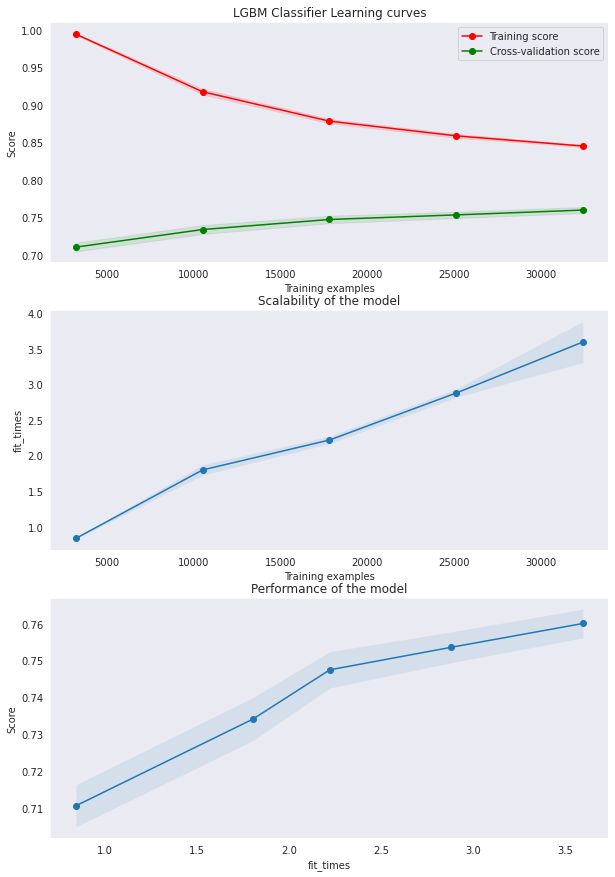

In [61]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
X,y = df_clean.loc[:,df_clean.columns!='completed'],df_clean.completed

cv = ShuffleSplit(n_splits=10,test_size=.2)

title = 'LGBM Classifier Learning curves'
plot_learning_curve(estimator=faster_estimator,title=title,X=X,y=y,axes=axes,cv=cv,n_jobs=-1);

performance is steadily improving with increasing data (which happens with the XGBClassifier as well) so applying this model to a large-scale data infrastructure would give us even better results than the ones we have now

In [62]:
import seaborn as sns

Now let's look at how the features correlate with the target variable

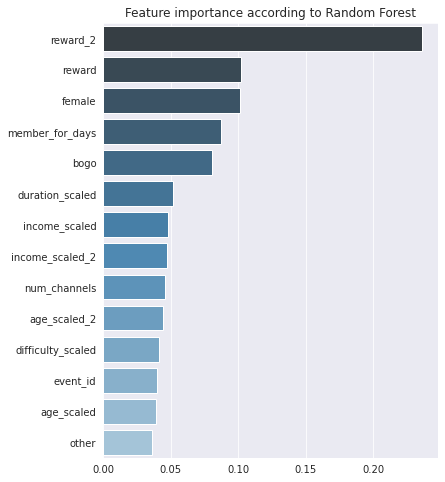

In [63]:
feat_importance = pd.Series(
    data=fitted_models['XGBClassifier'].feature_importances_, index=df_clean.drop(columns=['completed']).columns).sort_values(ascending=False)
plt.figure(figsize=(6,8))
plt.title("Feature importance according to Random Forest")
ax = sns.barplot(
    y=feat_importance.index, x=feat_importance.values, palette="Blues_d", orient='h')

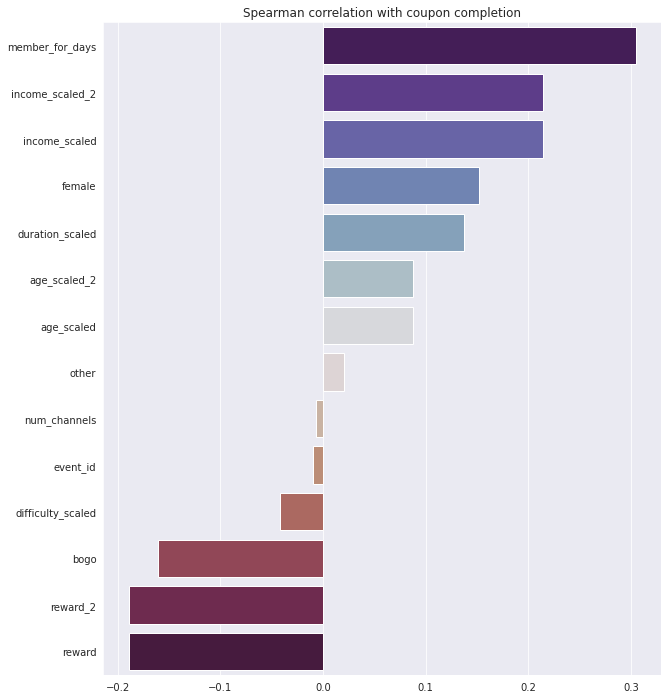

In [64]:
important_feats = df_clean.corr(method='spearman')['completed']\
  .drop('completed').sort_values(ascending=False)

fig = plt.figure(figsize=(10,12))
plt.title('Spearman correlation with coupon completion')
fig = sns.barplot(y=important_feats.index,x=important_feats.values,
                  palette='twilight_shifted',orient='h')

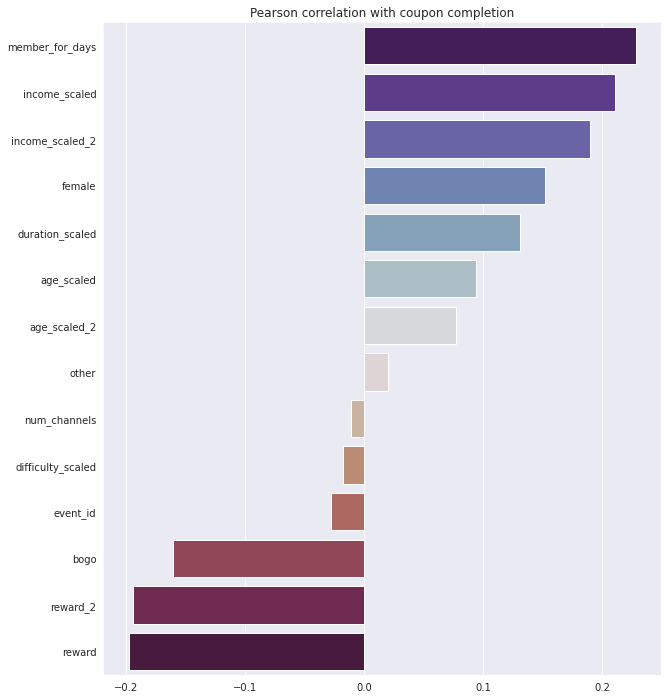

In [65]:
important_feats = df_clean.corr(method='pearson')['completed']\
  .drop('completed').sort_values(ascending=False)

fig = plt.figure(figsize=(10,12))
plt.title('Pearson correlation with coupon completion')
fig = sns.barplot(y=important_feats.index,x=important_feats.values,
                  palette='twilight_shifted',orient='h')

The surprising takeaway here is that reward and reward^2 are negatively correlated with redemption, so reward may be correlated with an ommitted variable. Another interpretation is that for bogo, reward = difficulty, so more expensive bogo's were less likely to be picked. Let's try checking the correlation of discount coupons with our input variables.

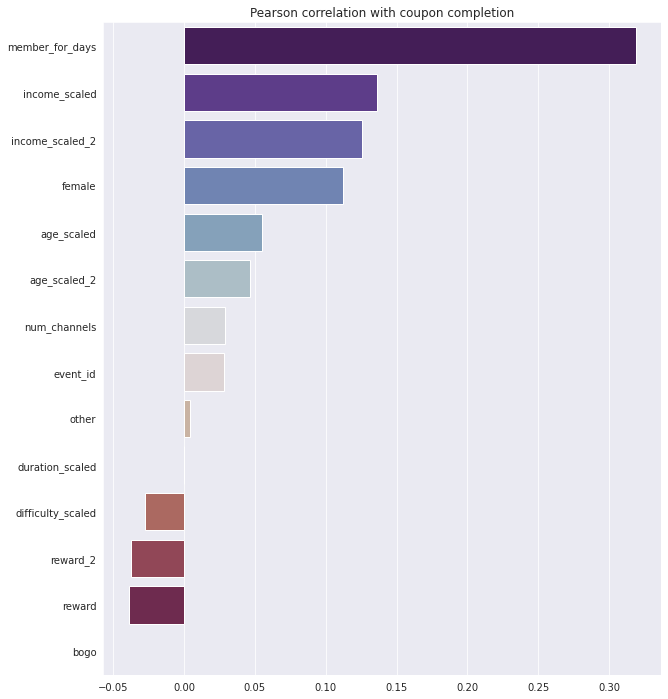

In [66]:
important_feats = df_clean[df_clean.bogo==0].corr(method='pearson')['completed']\
  .drop('completed').sort_values(ascending=False)

fig = plt.figure(figsize=(10,12))
plt.title('Pearson correlation with coupon completion')
fig = sns.barplot(y=important_feats.index,x=important_feats.values,
                  palette='twilight_shifted',orient='h')

reward is stil slightly negative, so we could interpret this to mean that the more expensive coupons have a lower bang-for-your-buck appeal. 

### OPTIONAL MATERIAL ###


this shows the scalability of the XGBoost model. It performs significantly better than the LGBM model at low amounts of training data, but about the same at the current level. This cell will take a long time to run, and it's not much more informative than the LGBM plots, so I dont reccomend running it unless you're willing to wait about 30 minutes. 

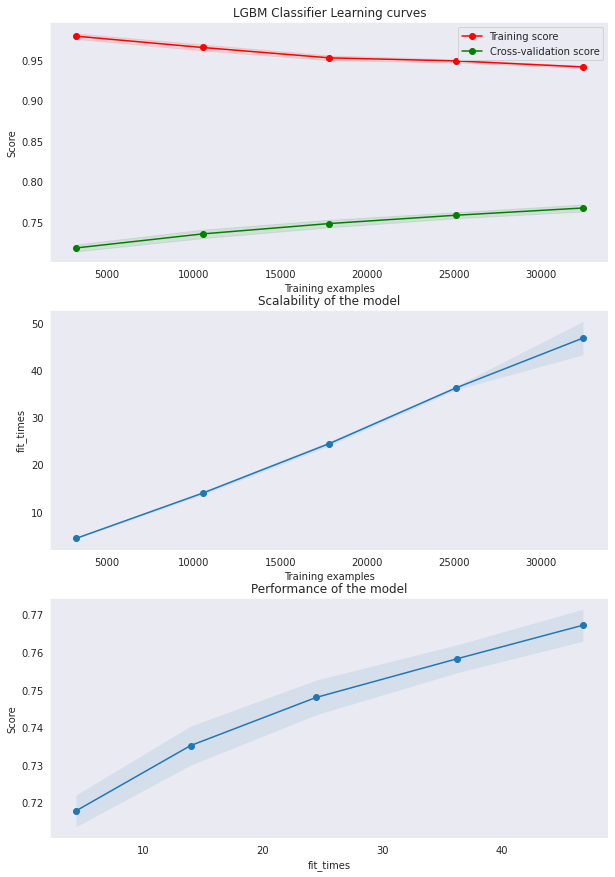

In [67]:
fig,axes = plt.subplots(3,1,figsize=(10,15))
X,y = df_clean.loc[:,df_clean.columns!='completed'],df_clean.completed

cv = ShuffleSplit(n_splits=10,test_size=.2)

title = 'LGBM Classifier Learning curves'
plot_learning_curve(estimator=best_estimator,title=title,X=X,y=y,axes=axes,cv=cv,n_jobs=-1);